In [1]:
from typing import Literal

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer

from joblib import dump, load

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
base_df = pd.read_csv('/content/STORM_preprocessed_medianfill_1.csv')

In [3]:
LINEAR_TARGETS = ["TotalDeaths", "NoInjured", "TotalDamageAdjusted(000US$)"]
CATEGORICAL_TARGETS = ['Flood', 'Slide']
ATTRIBUTES = ['Year', 'Month', 'MainLandfallLocation', 'OFDAResponse', 'Appeal', 'Declaration', 'LandfallMagnitude(kph)', 'LandfallPressure(mb)']

In [4]:
#from src.const import DATA_HEAD, WEIGHTS_HEAD
from const import WEIGHTS_HEAD, DATA_HEAD

data_filename = "STORM_preprocessed_medianfill_1.csv"
base_df = pd.read_csv(str(data_filename), index_col=0)
base_df.head()

,ID,EventName,Year,Month,DisasterType,DisasterSubtype,MainLandfallLocation,Flood,Slide,OFDAResponse,Appeal,Declaration,LandfallMagnitude(kph),LandfallPressure(mb),TotalDeaths,NoInjured,TotalDamage(000US$),TotalDamageAdjusted(000US$),CPI
0,STORM_NAN_1953,NaN,1953,9,Storm,Tropical cyclone,8,0,0,0,0,0,92,989,1000,20,19400,211880,9.156133
1,STORM_VIOLET_1964,Violet,1964,9,Storm,Tropical cyclone,4,1,1,0,0,0,92,989,18,20,10000,94354,10.598376
2,STORM_IRIS_1964,Iris,1964,11,Storm,Tropical cyclone,5,1,0,0,0,0,150,960,5100,20,70000,660479,10.598376
3,STORM_JOAN_1964,Joan,1964,11,Storm,Tropical cyclone,5,1,0,0,0,0,130,980,2500,20,15000,141531,10.598376
4,STORM_KATE_1964,Kate,1964,11,Storm,Tropical cyclone,6,1,0,0,0,0,130,970,0,20,3000,28306,10.598376


# Featue importance

target: death, injure, total dmg adjust . metric: mse, terminate the large error in predict dmg, phu hop voi gbms


| **Mô hình**               | **Ưu điểm**                            | **Nhược điểm**                          | **Khi nào dùng?**                       |
|---------------------------|----------------------------------------|-----------------------------------------|----------------------------------------|
| XGBoost                   | Hiệu quả cao, chống overfitting        | Tốn tài nguyên, huấn luyện chậm         | Dữ liệu lớn, nhiều tính năng                   |
| LightGBM                  | Nhanh, hiệu quả trên dữ liệu lớn       | Thiếu chính xác với dữ liệu nhỏ         | Dữ liệu lớn, cần tốc độ        |
| CatBoost                  | Tốt cho dữ liệu phân loại              | Cần nhiều tài nguyên                    | Khi có nhiều tính năng phân loại                       |
| AdaBoost                  | Đơn giản, dễ triển khai                | Hiệu suất kém hơn các GBM khác          | Dữ liệu nhỏ, ít biến động                       |
| Decision Trees (GBDT)     | Dự đoán chính xác với dữ liệu phi tuyến| Chậm khi số lượng cây lớn               | Dữ liệu phi tuyến, phức tạp                     |
| NGBoost                   | Mô hình hóa phân phối xác suất         | Phức tạp hơn, ít phổ biến               | Khi cần dự đoán phân phối xác suất                   |

**Model selection**
1. `XGBoost`
   - XGBoost is highly effective for data that contains both linear and non-linear relationships.
   - It is suitable for datasets with many features, where overfitting might be a concern. XGBoost provides robust feature importance, making it ideal for understanding key factors in complex datasets.
2. `LightGBM`
   - LightGBM is a fast and efficient model that is particularly effective on datasets with a large number of features.
   - It is suitable when quick training is required without sacrificing performance, making it a strong option when speed is prioritized and feature importance needs to be calculated quickly.
3. `CatBoost`
   - CatBoost is designed to handle datasets with many categorical variables without the need for extensive preprocessing, such as one-hot encoding.
   - It is particularly useful when working with datasets that contain mixed feature types (numerical and categorical) and when minimal data preprocessing is desired, while still delivering accurate feature importance.
4. `Decision Trees (GBDT)`
   - Decision Trees (GBDT) are effective at capturing complex, non-linear patterns in data.
   - It is suitable for datasets with non-linear relationships and complex interactions between features, especially when the goal is to model accurate predictions while identifying the most important features contributing to those predictions.

# 1. LINEAR_TARGET


## 1.1.  No Death

In [31]:
from const import LINEAR_TARGETS

evaluate_dict = dict()

print(f"LINEAR_TARGETS :{LINEAR_TARGETS[0]}")
print(f"ATTRIBUTES :{ATTRIBUTES + CATEGORICAL_TARGETS}")

slide_df = base_df.copy()
X = slide_df[ATTRIBUTES + CATEGORICAL_TARGETS]
y = slide_df[LINEAR_TARGETS[0]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train size {len(X_train)}")
print(f"Test size: {len(X_test)}")

LINEAR_TARGETS :TotalDeaths
ATTRIBUTES :['Year', 'Month', 'MainLandfallLocation', 'OFDAResponse', 'Appeal', 'Declaration', 'LandfallMagnitude(kph)', 'LandfallPressure(mb)', 'Flood', 'Slide']
Train size 147
Test size: 37


### 1.1.1 XGBOOST

In [6]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [7]:
feature_names = ATTRIBUTES + CATEGORICAL_TARGETS
xgb_importance = xgb_model.feature_importances_

# Create a DataFrame for feature importance
xgb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importance
}).sort_values(by='Importance', ascending=False)
print(xgb_importance_df)


                  Feature  Importance
0                    Year    0.396318
6  LandfallMagnitude(kph)    0.317871
2    MainLandfallLocation    0.075518
1                   Month    0.071624
7    LandfallPressure(mb)    0.062361
3            OFDAResponse    0.060686
4                  Appeal    0.012395
9                   Slide    0.002352
8                   Flood    0.000875
5             Declaration    0.000000


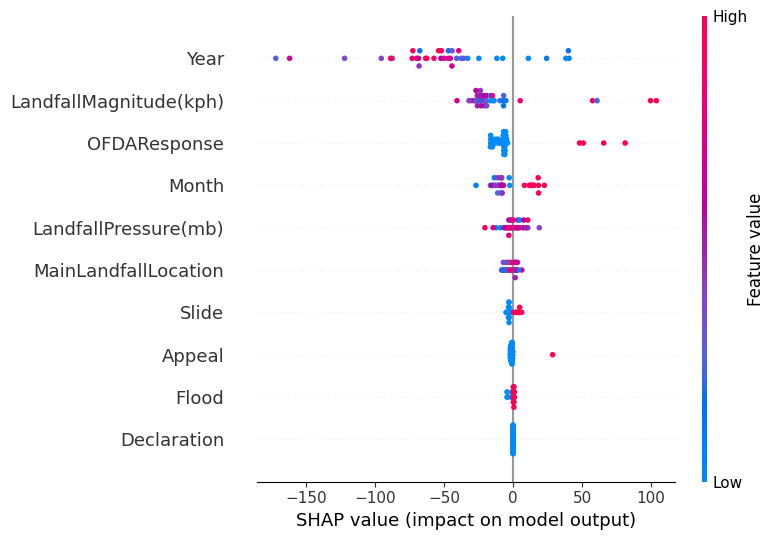

In [8]:
import shap
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 1.1.2 LightGBM

In [9]:
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 107
[LightGBM] [Info] Number of data points in the train set: 147, number of used features: 7
[LightGBM] [Info] Start training from score 106.857143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

LGBMRegressor()

In [10]:
lgb_importance = lgb_model.feature_importances_
lgb_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': lgb_importance}).sort_values(by='Importance', ascending=False)
print(lgb_importance_df)

                  Feature  Importance
0                    Year         173
1                   Month         104
6  LandfallMagnitude(kph)          97
7    LandfallPressure(mb)          53
9                   Slide          17
2    MainLandfallLocation          14
3            OFDAResponse           0
4                  Appeal           0
5             Declaration           0
8                   Flood           0


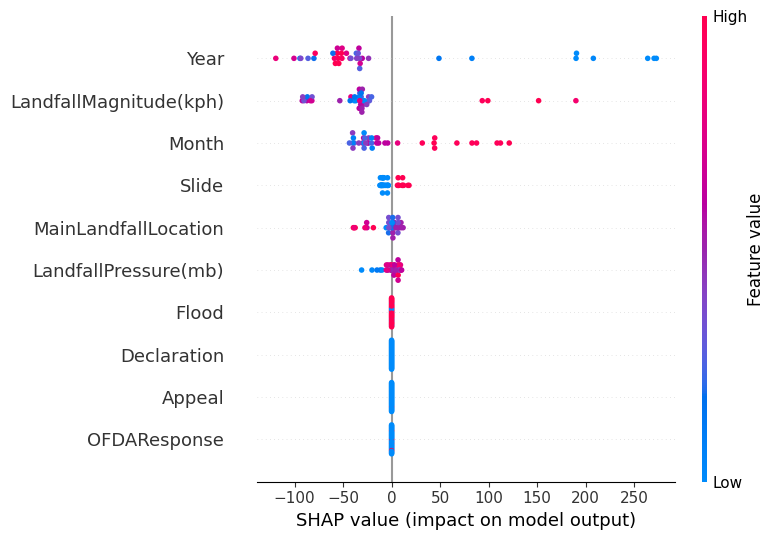

In [11]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)

# Plot the feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 1.1.3 CatBoost

In [12]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.6 MB/s eta 0:00:00


In [13]:
from catboost import CatBoostRegressor
cat_model = CatBoostRegressor()
cat_model.fit(X_train, y_train)

Learning rate set to 0.030242
0:	learn: 474.8935653	total: 46.9ms	remaining: 46.8s
1:	learn: 471.3640040	total: 47.6ms	remaining: 23.7s
2:	learn: 468.0167703	total: 48.2ms	remaining: 16s
3:	learn: 464.5655498	total: 48.8ms	remaining: 12.2s
4:	learn: 461.0471589	total: 49.4ms	remaining: 9.82s
5:	learn: 457.8991406	total: 49.9ms	remaining: 8.27s
6:	learn: 454.6768441	total: 50.5ms	remaining: 7.16s
7:	learn: 451.5365131	total: 51ms	remaining: 6.33s
8:	learn: 448.4834973	total: 51.6ms	remaining: 5.68s
9:	learn: 445.1840673	total: 52.2ms	remaining: 5.17s
10:	learn: 441.9371963	total: 52.7ms	remaining: 4.74s
11:	learn: 438.6976759	total: 53.3ms	remaining: 4.39s
12:	learn: 435.4896915	total: 53.9ms	remaining: 4.09s
13:	learn: 432.2595625	total: 54.4ms	remaining: 3.83s
14:	learn: 429.0760846	total: 55ms	remaining: 3.61s
15:	learn: 426.1680837	total: 55.6ms	remaining: 3.42s
16:	learn: 423.0339016	total: 56.2ms	remaining: 3.25s
17:	learn: 419.9474727	total: 56.8ms	remaining: 3.1s
18:	learn: 416.

In [14]:
cat_importance = cat_model.feature_importances_
cat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': cat_importance}).sort_values(by='Importance', ascending=False)
print(cat_importance_df)

                  Feature  Importance
0                    Year   58.217045
7    LandfallPressure(mb)   14.813903
6  LandfallMagnitude(kph)   14.499775
2    MainLandfallLocation    6.891082
1                   Month    2.524050
9                   Slide    1.516541
4                  Appeal    0.587349
3            OFDAResponse    0.478096
8                   Flood    0.472158
5             Declaration    0.000000


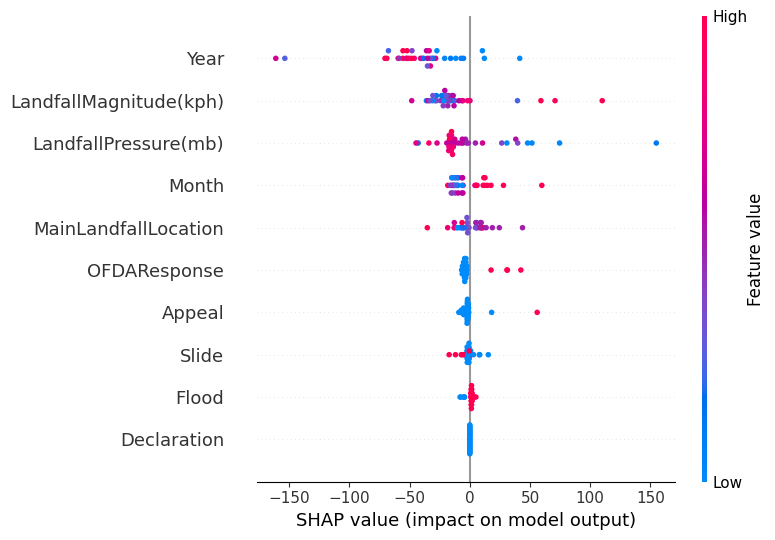

In [15]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_test)

# Plot the feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 1.1.4 Decision Trees (GBDT)

In [16]:
from sklearn.ensemble import GradientBoostingRegressor  # GBDT từ scikit-learn
gbdt_model = GradientBoostingRegressor().fit(X_train, y_train)

In [17]:
gbdt_importance = gbdt_model.feature_importances_
gbdt_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': gbdt_importance}).sort_values(by='Importance', ascending=False)
print(gbdt_importance_df)

                  Feature  Importance
0                    Year    0.412958
6  LandfallMagnitude(kph)    0.254810
7    LandfallPressure(mb)    0.218539
2    MainLandfallLocation    0.061420
1                   Month    0.031030
9                   Slide    0.014336
4                  Appeal    0.003357
3            OFDAResponse    0.003140
8                   Flood    0.000410
5             Declaration    0.000000


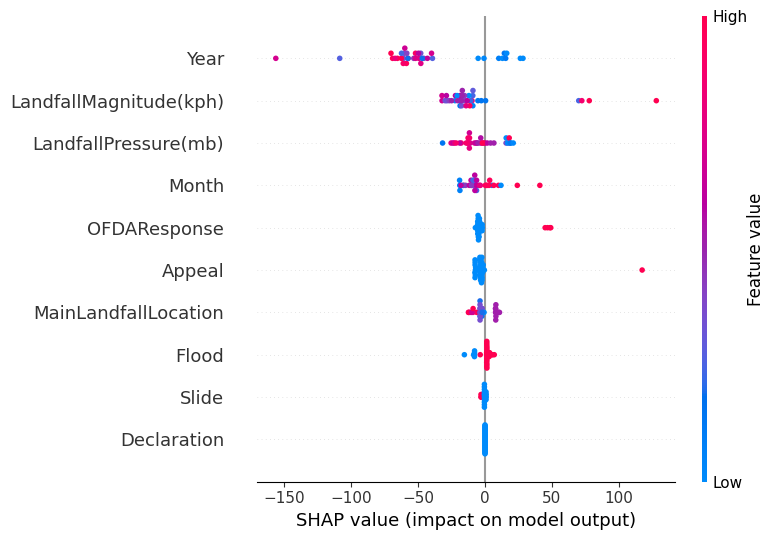

In [18]:
explainer = shap.TreeExplainer(gbdt_model)
shap_values = explainer.shap_values(X_test)

# Plot the feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)


### 1.1.5 COMPARISION

In [34]:
# Normalize and rank feature importance for each model
xgb_importance_df['Rank'] = xgb_importance_df['Importance'].rank(ascending=False)
lgb_importance_df['Rank'] = lgb_importance_df['Importance'].rank(ascending=False)
cat_importance_df['Rank'] = cat_importance_df['Importance'].rank(ascending=False)
gbdt_importance_df['Rank'] = gbdt_importance_df['Importance'].rank(ascending=False)

# Combine rankings into a single DataFrame
combined_ranks = pd.concat([
    xgb_importance_df.set_index('Feature')['Rank'].rename('XGBoost'),
    lgb_importance_df.set_index('Feature')['Rank'].rename('LightGBM'),
    cat_importance_df.set_index('Feature')['Rank'].rename('CatBoost'),
    gbdt_importance_df.set_index('Feature')['Rank'].rename('GBDT')
], axis=1)

# Calculate average rank for each feature across all models
combined_ranks['Average Rank'] = combined_ranks.mean(axis=1)

# Sort by average rank to identify the most important features
sorted_ranks = combined_ranks.sort_values(by='Average Rank')
print("Feature Rankings by Average Rank Across Models:")
print(sorted_ranks)


Feature Rankings by Average Rank Across Models:
                        XGBoost  LightGBM  CatBoost  GBDT  Average Rank
Feature                                                                
Year                        1.0       1.0       1.0   1.0         1.000
LandfallMagnitude(kph)      2.0       3.0       3.0   2.0         2.500
LandfallPressure(mb)        5.0       4.0       2.0   3.0         3.500
Month                       4.0       2.0       5.0   5.0         4.000
MainLandfallLocation        3.0       6.0       4.0   4.0         4.250
Slide                       8.0       5.0       6.0   6.0         6.250
Appeal                      7.0       8.5       7.0   7.0         7.375
OFDAResponse                6.0       8.5       8.0   8.0         7.625
Flood                       9.0       8.5       9.0   9.0         8.875
Declaration                10.0       8.5      10.0  10.0         9.625


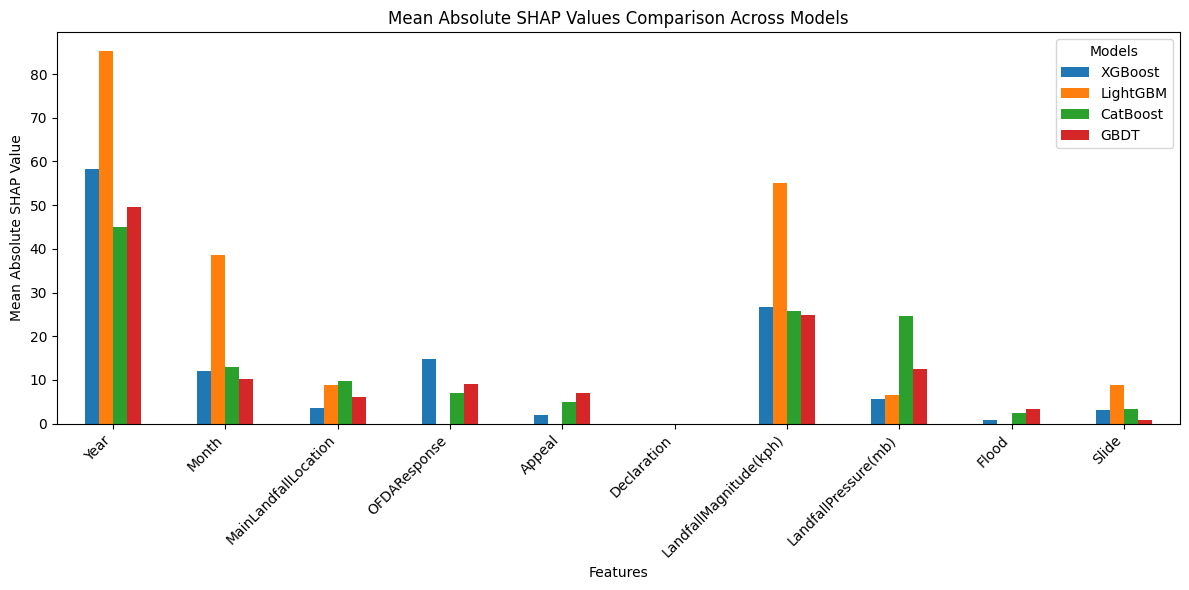

In [33]:
# Plot combined SHAP feature importance for all models
mean_abs_shap_df.plot(kind='bar', figsize=(12, 6))
plt.title('Mean Absolute SHAP Values Comparison Across Models')
plt.ylabel('Mean Absolute SHAP Value')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Models', loc='upper right')
plt.tight_layout()
plt.show()

In [32]:
import shap
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

models = [xgb_model, lgb_model, cat_model, gbdt_model]
model_names = ['XGBoost', 'LightGBM', 'CatBoost', 'GBDT']
feature_names = X_test.columns
mean_abs_shap_values = {}
ranked_features = {}

for model, name in zip(models, model_names):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    mean_abs_shap_values[name] = mean_abs_shap

    ranked_features[name] = pd.Series(mean_abs_shap, index=feature_names).rank(ascending=False)

mean_abs_shap_df = pd.DataFrame(mean_abs_shap_values, index=feature_names)
ranked_features_df = pd.DataFrame(ranked_features, index=feature_names)

rank_correlation_matrix = ranked_features_df.corr(method='spearman')

print("Mean Absolute SHAP Values:")
print(mean_abs_shap_df)

print("\nRank Correlation Matrix:")
print(rank_correlation_matrix)

Mean Absolute SHAP Values:
                          XGBoost   LightGBM   CatBoost       GBDT
Year                    58.174931  85.295472  45.044696  49.517741
Month                   12.014859  38.545688  12.966990  10.200428
MainLandfallLocation     3.558130   8.868778   9.778090   6.174486
OFDAResponse            14.861990   0.000000   6.987665   9.127686
Appeal                   1.866562   0.000000   5.049287   7.005595
Declaration              0.000000   0.000000   0.000000   0.000000
LandfallMagnitude(kph)  26.624462  55.006275  25.662898  24.750899
LandfallPressure(mb)     5.550518   6.504171  24.649947  12.563829
Flood                    0.825314   0.000000   2.419387   3.434879
Slide                    3.092112   8.942786   3.263049   0.886362

Rank Correlation Matrix:
           XGBoost  LightGBM  CatBoost      GBDT
XGBoost   1.000000  0.719101  0.903030  0.890909
LightGBM  0.719101  1.000000  0.769126  0.625305
CatBoost  0.903030  0.769126  1.000000  0.951515
GBDT      0.89

## 1.2.  No Injured

In [35]:
from const import LINEAR_TARGETS

evaluate_dict = dict()

print(f"LINEAR_TARGETS :{LINEAR_TARGETS[1]}")
print(f"ATTRIBUTES :{ATTRIBUTES + CATEGORICAL_TARGETS}")

slide_df = base_df.copy()
X = slide_df[ATTRIBUTES + CATEGORICAL_TARGETS]
y = slide_df[LINEAR_TARGETS[0]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train size {len(X_train)}")
print(f"Test size: {len(X_test)}")

LINEAR_TARGETS :NoInjured
ATTRIBUTES :['Year', 'Month', 'MainLandfallLocation', 'OFDAResponse', 'Appeal', 'Declaration', 'LandfallMagnitude(kph)', 'LandfallPressure(mb)', 'Flood', 'Slide']
Train size 147
Test size: 37


### 1.2.1 XGBOOST

In [36]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [37]:
feature_names = ATTRIBUTES + CATEGORICAL_TARGETS
xgb_importance = xgb_model.feature_importances_

# Create a DataFrame for feature importance
xgb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importance
}).sort_values(by='Importance', ascending=False)
print(xgb_importance_df)


                  Feature  Importance
0                    Year    0.396318
6  LandfallMagnitude(kph)    0.317871
2    MainLandfallLocation    0.075518
1                   Month    0.071624
7    LandfallPressure(mb)    0.062361
3            OFDAResponse    0.060686
4                  Appeal    0.012395
9                   Slide    0.002352
8                   Flood    0.000875
5             Declaration    0.000000


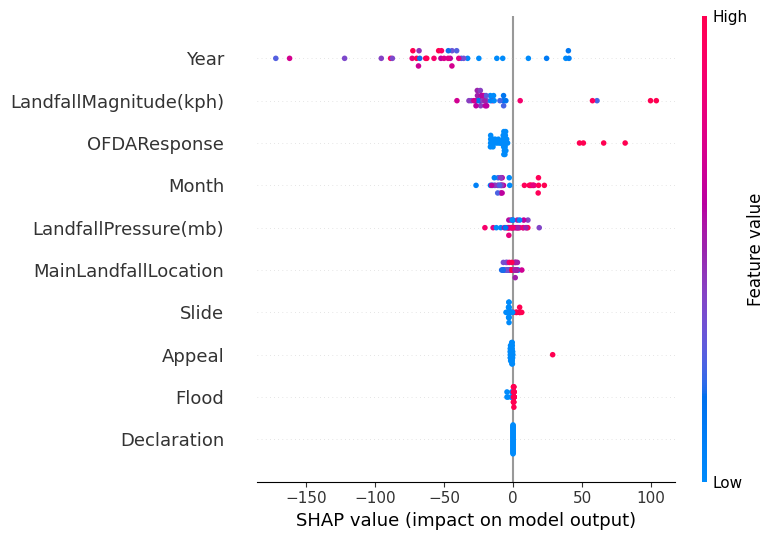

In [38]:
import shap
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 1.2.2 LightGBM

In [39]:
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 107
[LightGBM] [Info] Number of data points in the train set: 147, number of used features: 7
[LightGBM] [Info] Start training from score 106.857143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

LGBMRegressor()

In [40]:
lgb_importance = lgb_model.feature_importances_
lgb_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': lgb_importance}).sort_values(by='Importance', ascending=False)
print(lgb_importance_df)

                  Feature  Importance
0                    Year         173
1                   Month         104
6  LandfallMagnitude(kph)          97
7    LandfallPressure(mb)          53
9                   Slide          17
2    MainLandfallLocation          14
3            OFDAResponse           0
4                  Appeal           0
5             Declaration           0
8                   Flood           0


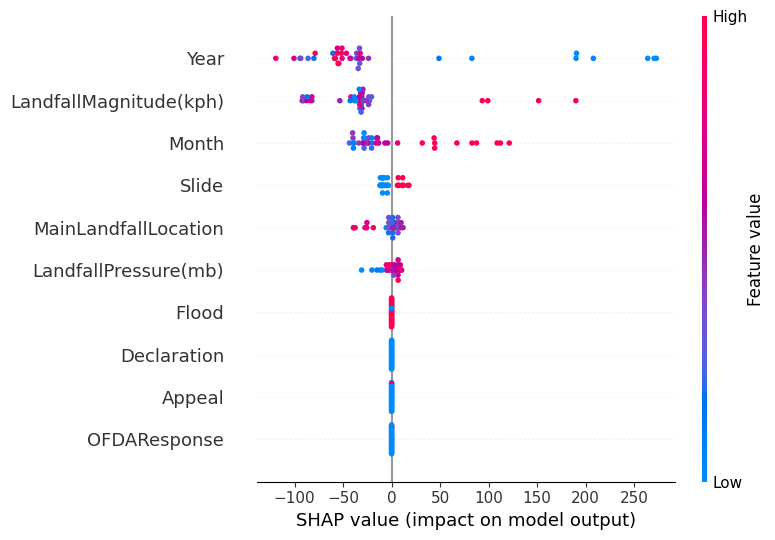

In [41]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)

# Plot the feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)


### 1.2.3 CatBoost

In [42]:
# !pip install catboost

In [43]:
from catboost import CatBoostRegressor
cat_model = CatBoostRegressor()
cat_model.fit(X_train, y_train)

Learning rate set to 0.030242
0:	learn: 474.8935653	total: 1.36ms	remaining: 1.36s
1:	learn: 471.3640040	total: 1.72ms	remaining: 856ms
2:	learn: 468.0167703	total: 2.05ms	remaining: 682ms
3:	learn: 464.5655498	total: 2.65ms	remaining: 661ms
4:	learn: 461.0471589	total: 3.23ms	remaining: 642ms
5:	learn: 457.8991406	total: 3.8ms	remaining: 630ms
6:	learn: 454.6768441	total: 4.39ms	remaining: 623ms
7:	learn: 451.5365131	total: 4.95ms	remaining: 613ms
8:	learn: 448.4834973	total: 5.51ms	remaining: 607ms
9:	learn: 445.1840673	total: 6.09ms	remaining: 603ms
10:	learn: 441.9371963	total: 6.66ms	remaining: 599ms
11:	learn: 438.6976759	total: 7.22ms	remaining: 594ms
12:	learn: 435.4896915	total: 7.79ms	remaining: 591ms
13:	learn: 432.2595625	total: 8.36ms	remaining: 589ms
14:	learn: 429.0760846	total: 8.91ms	remaining: 585ms
15:	learn: 426.1680837	total: 9.5ms	remaining: 584ms
16:	learn: 423.0339016	total: 10.1ms	remaining: 583ms
17:	learn: 419.9474727	total: 10.6ms	remaining: 580ms
18:	learn:

In [44]:
cat_importance = cat_model.feature_importances_
cat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': cat_importance}).sort_values(by='Importance', ascending=False)
print(cat_importance_df)

                  Feature  Importance
0                    Year   58.217045
7    LandfallPressure(mb)   14.813903
6  LandfallMagnitude(kph)   14.499775
2    MainLandfallLocation    6.891082
1                   Month    2.524050
9                   Slide    1.516541
4                  Appeal    0.587349
3            OFDAResponse    0.478096
8                   Flood    0.472158
5             Declaration    0.000000


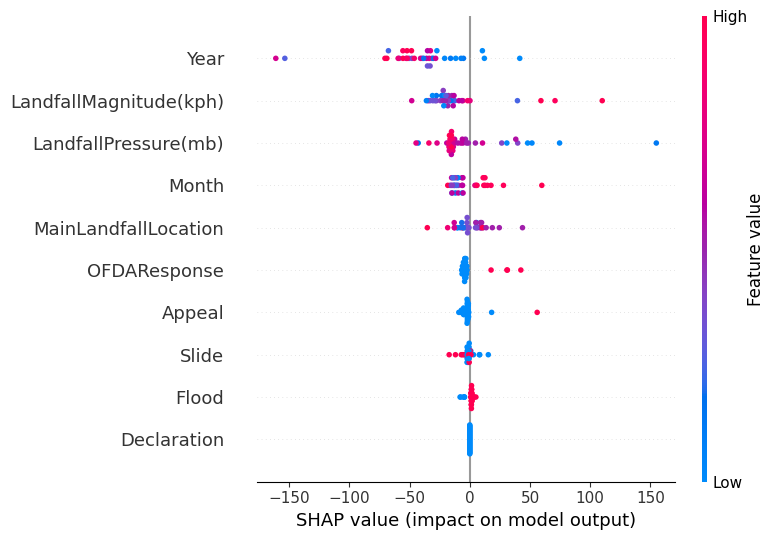

In [45]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_test)

# Plot the feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)


### 1.2.4 Decision Trees (GBDT)

In [46]:
gbdt_model = GradientBoostingRegressor().fit(X_train, y_train)

In [47]:
gbdt_importance = gbdt_model.feature_importances_
gbdt_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': gbdt_importance}).sort_values(by='Importance', ascending=False)
print(gbdt_importance_df)

                  Feature  Importance
0                    Year    0.411782
6  LandfallMagnitude(kph)    0.236040
7    LandfallPressure(mb)    0.224504
2    MainLandfallLocation    0.057616
9                   Slide    0.053975
1                   Month    0.007612
3            OFDAResponse    0.003611
4                  Appeal    0.002886
8                   Flood    0.001974
5             Declaration    0.000000


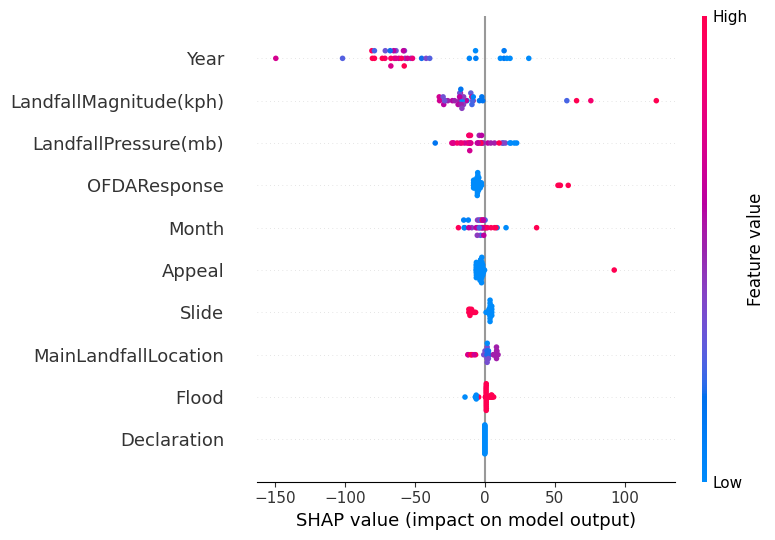

In [48]:
explainer = shap.TreeExplainer(gbdt_model)
shap_values = explainer.shap_values(X_test)

# Plot the feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 1.1.5 COMPARISION

In [49]:
# Normalize and rank feature importance for each model
xgb_importance_df['Rank'] = xgb_importance_df['Importance'].rank(ascending=False)
lgb_importance_df['Rank'] = lgb_importance_df['Importance'].rank(ascending=False)
cat_importance_df['Rank'] = cat_importance_df['Importance'].rank(ascending=False)
gbdt_importance_df['Rank'] = gbdt_importance_df['Importance'].rank(ascending=False)

# Combine rankings into a single DataFrame
combined_ranks = pd.concat([
    xgb_importance_df.set_index('Feature')['Rank'].rename('XGBoost'),
    lgb_importance_df.set_index('Feature')['Rank'].rename('LightGBM'),
    cat_importance_df.set_index('Feature')['Rank'].rename('CatBoost'),
    gbdt_importance_df.set_index('Feature')['Rank'].rename('GBDT')
], axis=1)

# Calculate average rank for each feature across all models
combined_ranks['Average Rank'] = combined_ranks.mean(axis=1)

# Sort by average rank to identify the most important features
sorted_ranks = combined_ranks.sort_values(by='Average Rank')
print("Feature Rankings by Average Rank Across Models:")
print(sorted_ranks)


Feature Rankings by Average Rank Across Models:
                        XGBoost  LightGBM  CatBoost  GBDT  Average Rank
Feature                                                                
Year                        1.0       1.0       1.0   1.0         1.000
LandfallMagnitude(kph)      2.0       3.0       3.0   2.0         2.500
LandfallPressure(mb)        5.0       4.0       2.0   3.0         3.500
MainLandfallLocation        3.0       6.0       4.0   4.0         4.250
Month                       4.0       2.0       5.0   6.0         4.250
Slide                       8.0       5.0       6.0   5.0         6.000
OFDAResponse                6.0       8.5       8.0   7.0         7.375
Appeal                      7.0       8.5       7.0   8.0         7.625
Flood                       9.0       8.5       9.0   9.0         8.875
Declaration                10.0       8.5      10.0  10.0         9.625


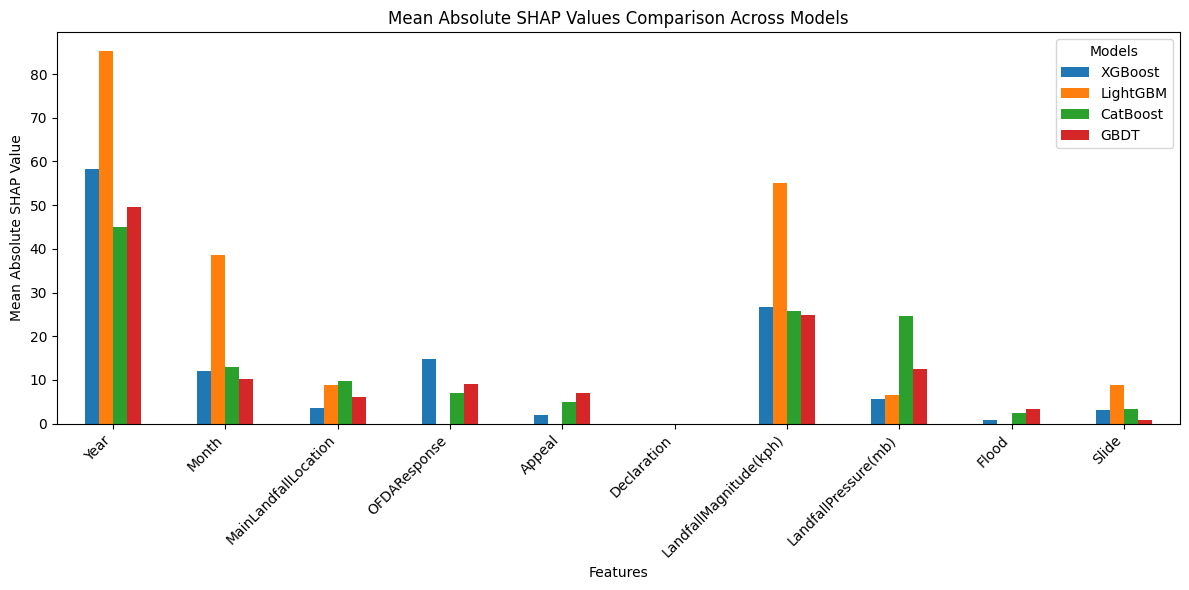

In [50]:
# Plot combined SHAP feature importance for all models
mean_abs_shap_df.plot(kind='bar', figsize=(12, 6))
plt.title('Mean Absolute SHAP Values Comparison Across Models')
plt.ylabel('Mean Absolute SHAP Value')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Models', loc='upper right')
plt.tight_layout()
plt.show()

In [51]:
import shap
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

models = [xgb_model, lgb_model, cat_model, gbdt_model]
model_names = ['XGBoost', 'LightGBM', 'CatBoost', 'GBDT']
feature_names = X_test.columns
mean_abs_shap_values = {}
ranked_features = {}

for model, name in zip(models, model_names):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    mean_abs_shap_values[name] = mean_abs_shap

    ranked_features[name] = pd.Series(mean_abs_shap, index=feature_names).rank(ascending=False)

mean_abs_shap_df = pd.DataFrame(mean_abs_shap_values, index=feature_names)
ranked_features_df = pd.DataFrame(ranked_features, index=feature_names)

rank_correlation_matrix = ranked_features_df.corr(method='spearman')

print("Mean Absolute SHAP Values:")
print(mean_abs_shap_df)

print("\nRank Correlation Matrix:")
print(rank_correlation_matrix)

Mean Absolute SHAP Values:
                          XGBoost   LightGBM   CatBoost       GBDT
Year                    58.174931  85.295472  45.044696  54.367760
Month                   12.014859  38.545688  12.966990   6.393831
MainLandfallLocation     3.558130   8.868778   9.778090   5.203264
OFDAResponse            14.861990   0.000000   6.987665  10.782189
Appeal                   1.866562   0.000000   5.049287   5.755261
Declaration              0.000000   0.000000   0.000000   0.000000
LandfallMagnitude(kph)  26.624462  55.006275  25.662898  23.913208
LandfallPressure(mb)     5.550518   6.504171  24.649947  12.024888
Flood                    0.825314   0.000000   2.419387   3.034027
Slide                    3.092112   8.942786   3.263049   5.335384

Rank Correlation Matrix:
           XGBoost  LightGBM  CatBoost      GBDT
XGBoost   1.000000  0.719101  0.903030  0.915152
LightGBM  0.719101  1.000000  0.769126  0.625305
CatBoost  0.903030  0.769126  1.000000  0.903030
GBDT      0.91

## 1.3.  Adjusted Damage

In [52]:
from const import LINEAR_TARGETS

evaluate_dict = dict()

print(f"LINEAR_TARGETS :{LINEAR_TARGETS[2]}")
print(f"ATTRIBUTES :{ATTRIBUTES + CATEGORICAL_TARGETS}")

slide_df = base_df.copy()
X = slide_df[ATTRIBUTES + CATEGORICAL_TARGETS]
y = slide_df[LINEAR_TARGETS[0]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train size {len(X_train)}")
print(f"Test size: {len(X_test)}")

LINEAR_TARGETS :TotalDamageAdjusted(000US$)
ATTRIBUTES :['Year', 'Month', 'MainLandfallLocation', 'OFDAResponse', 'Appeal', 'Declaration', 'LandfallMagnitude(kph)', 'LandfallPressure(mb)', 'Flood', 'Slide']
Train size 147
Test size: 37


### 1.3.1 XGBOOST

In [53]:
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [54]:
feature_names = ATTRIBUTES + CATEGORICAL_TARGETS
xgb_importance = xgb_model.feature_importances_

# Create a DataFrame for feature importance
xgb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importance
}).sort_values(by='Importance', ascending=False)
print(xgb_importance_df)


                  Feature  Importance
0                    Year    0.396318
6  LandfallMagnitude(kph)    0.317871
2    MainLandfallLocation    0.075518
1                   Month    0.071624
7    LandfallPressure(mb)    0.062361
3            OFDAResponse    0.060686
4                  Appeal    0.012395
9                   Slide    0.002352
8                   Flood    0.000875
5             Declaration    0.000000


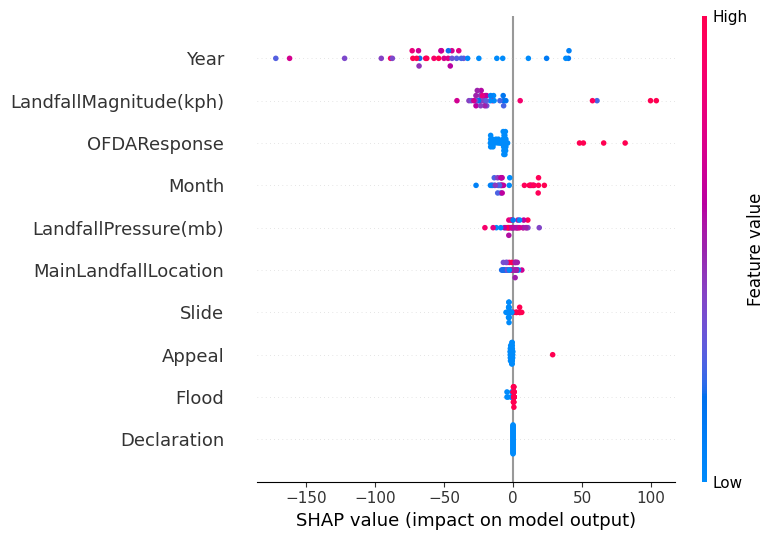

In [55]:
import shap
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 1.3.2 LightGBM

In [56]:
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 107
[LightGBM] [Info] Number of data points in the train set: 147, number of used features: 7
[LightGBM] [Info] Start training from score 106.857143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

LGBMRegressor()

In [57]:
lgb_importance = lgb_model.feature_importances_
lgb_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': lgb_importance}).sort_values(by='Importance', ascending=False)
print(lgb_importance_df)

                  Feature  Importance
0                    Year         173
1                   Month         104
6  LandfallMagnitude(kph)          97
7    LandfallPressure(mb)          53
9                   Slide          17
2    MainLandfallLocation          14
3            OFDAResponse           0
4                  Appeal           0
5             Declaration           0
8                   Flood           0


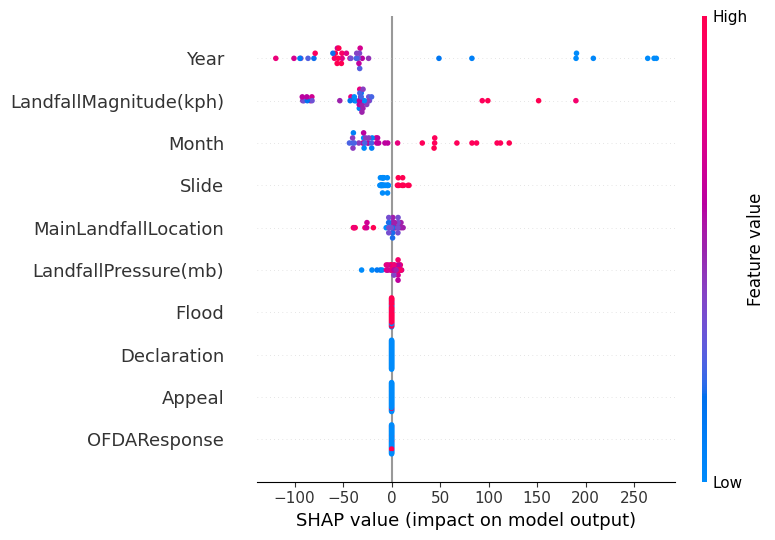

In [58]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)

# Plot the feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 1.3.3 CatBoost

In [59]:
# !pip install catboost

In [60]:
cat_model = CatBoostRegressor()
cat_model.fit(X_train, y_train)

Learning rate set to 0.030242
0:	learn: 474.8935653	total: 542us	remaining: 542ms
1:	learn: 471.3640040	total: 4.08ms	remaining: 2.04s
2:	learn: 468.0167703	total: 5.46ms	remaining: 1.81s
3:	learn: 464.5655498	total: 6.7ms	remaining: 1.67s
4:	learn: 461.0471589	total: 8.55ms	remaining: 1.7s
5:	learn: 457.8991406	total: 9.32ms	remaining: 1.54s
6:	learn: 454.6768441	total: 9.79ms	remaining: 1.39s
7:	learn: 451.5365131	total: 10.2ms	remaining: 1.26s
8:	learn: 448.4834973	total: 10.7ms	remaining: 1.17s
9:	learn: 445.1840673	total: 11.1ms	remaining: 1.1s
10:	learn: 441.9371963	total: 11.5ms	remaining: 1.04s
11:	learn: 438.6976759	total: 15.4ms	remaining: 1.26s
12:	learn: 435.4896915	total: 15.8ms	remaining: 1.2s
13:	learn: 432.2595625	total: 16.3ms	remaining: 1.15s
14:	learn: 429.0760846	total: 16.7ms	remaining: 1.1s
15:	learn: 426.1680837	total: 17.2ms	remaining: 1.06s
16:	learn: 423.0339016	total: 17.7ms	remaining: 1.02s
17:	learn: 419.9474727	total: 18.1ms	remaining: 988ms
18:	learn: 416

In [61]:
cat_importance = cat_model.feature_importances_
cat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': cat_importance}).sort_values(by='Importance', ascending=False)
print(cat_importance_df)

                  Feature  Importance
0                    Year   58.217045
7    LandfallPressure(mb)   14.813903
6  LandfallMagnitude(kph)   14.499775
2    MainLandfallLocation    6.891082
1                   Month    2.524050
9                   Slide    1.516541
4                  Appeal    0.587349
3            OFDAResponse    0.478096
8                   Flood    0.472158
5             Declaration    0.000000


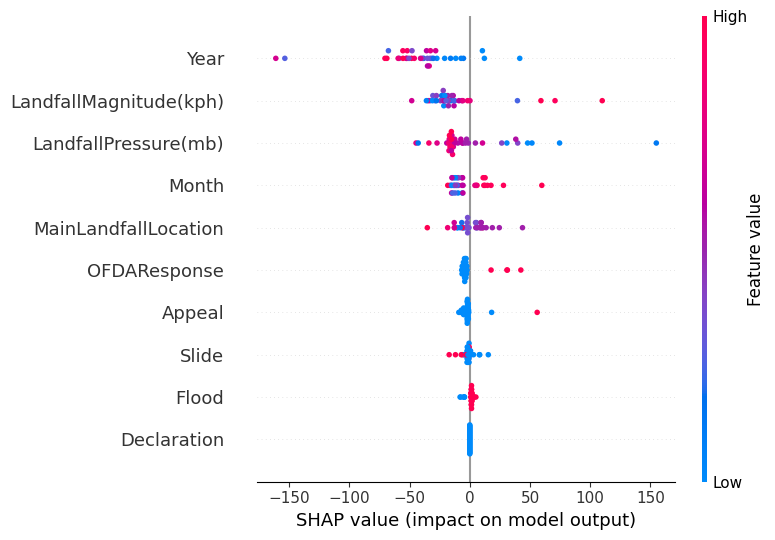

In [62]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_test)

# Plot the feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 1.3.4 Decision Trees (GBDT)

In [63]:
gbdt_model = GradientBoostingRegressor().fit(X_train, y_train)

In [64]:
gbdt_importance = gbdt_model.feature_importances_
gbdt_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': gbdt_importance}).sort_values(by='Importance', ascending=False)
print(gbdt_importance_df)

                  Feature  Importance
0                    Year    0.411805
6  LandfallMagnitude(kph)    0.287555
7    LandfallPressure(mb)    0.196444
2    MainLandfallLocation    0.049054
9                   Slide    0.035273
1                   Month    0.012703
3            OFDAResponse    0.003313
4                  Appeal    0.003184
8                   Flood    0.000670
5             Declaration    0.000000


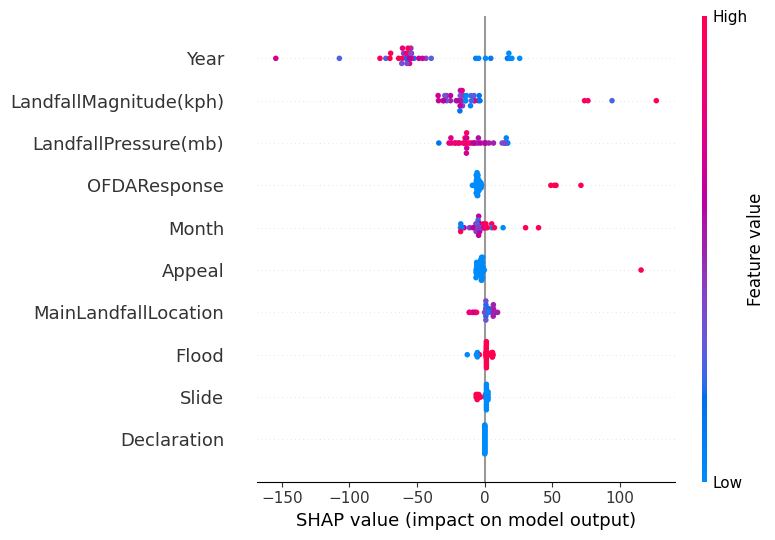

In [65]:
explainer = shap.TreeExplainer(gbdt_model)
shap_values = explainer.shap_values(X_test)

# Plot the feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)


### 1.1.5 COMPARISION

In [66]:
# Normalize and rank feature importance for each model
xgb_importance_df['Rank'] = xgb_importance_df['Importance'].rank(ascending=False)
lgb_importance_df['Rank'] = lgb_importance_df['Importance'].rank(ascending=False)
cat_importance_df['Rank'] = cat_importance_df['Importance'].rank(ascending=False)
gbdt_importance_df['Rank'] = gbdt_importance_df['Importance'].rank(ascending=False)

# Combine rankings into a single DataFrame
combined_ranks = pd.concat([
    xgb_importance_df.set_index('Feature')['Rank'].rename('XGBoost'),
    lgb_importance_df.set_index('Feature')['Rank'].rename('LightGBM'),
    cat_importance_df.set_index('Feature')['Rank'].rename('CatBoost'),
    gbdt_importance_df.set_index('Feature')['Rank'].rename('GBDT')
], axis=1)

# Calculate average rank for each feature across all models
combined_ranks['Average Rank'] = combined_ranks.mean(axis=1)

# Sort by average rank to identify the most important features
sorted_ranks = combined_ranks.sort_values(by='Average Rank')
print("Feature Rankings by Average Rank Across Models:")
print(sorted_ranks)


Feature Rankings by Average Rank Across Models:
                        XGBoost  LightGBM  CatBoost  GBDT  Average Rank
Feature                                                                
Year                        1.0       1.0       1.0   1.0         1.000
LandfallMagnitude(kph)      2.0       3.0       3.0   2.0         2.500
LandfallPressure(mb)        5.0       4.0       2.0   3.0         3.500
MainLandfallLocation        3.0       6.0       4.0   4.0         4.250
Month                       4.0       2.0       5.0   6.0         4.250
Slide                       8.0       5.0       6.0   5.0         6.000
OFDAResponse                6.0       8.5       8.0   7.0         7.375
Appeal                      7.0       8.5       7.0   8.0         7.625
Flood                       9.0       8.5       9.0   9.0         8.875
Declaration                10.0       8.5      10.0  10.0         9.625


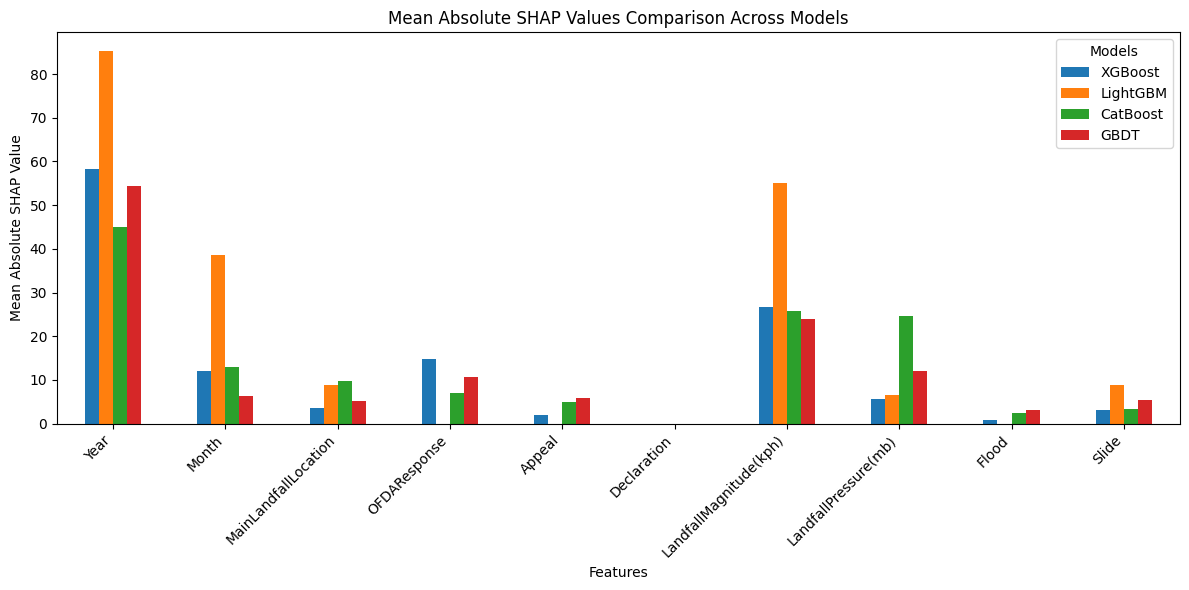

In [67]:
# Plot combined SHAP feature importance for all models
mean_abs_shap_df.plot(kind='bar', figsize=(12, 6))
plt.title('Mean Absolute SHAP Values Comparison Across Models')
plt.ylabel('Mean Absolute SHAP Value')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Models', loc='upper right')
plt.tight_layout()
plt.show()

In [68]:
import shap
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

models = [xgb_model, lgb_model, cat_model, gbdt_model]
model_names = ['XGBoost', 'LightGBM', 'CatBoost', 'GBDT']
feature_names = X_test.columns
mean_abs_shap_values = {}
ranked_features = {}

for model, name in zip(models, model_names):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    mean_abs_shap_values[name] = mean_abs_shap

    ranked_features[name] = pd.Series(mean_abs_shap, index=feature_names).rank(ascending=False)

mean_abs_shap_df = pd.DataFrame(mean_abs_shap_values, index=feature_names)
ranked_features_df = pd.DataFrame(ranked_features, index=feature_names)

rank_correlation_matrix = ranked_features_df.corr(method='spearman')

print("Mean Absolute SHAP Values:")
print(mean_abs_shap_df)

print("\nRank Correlation Matrix:")
print(rank_correlation_matrix)

Mean Absolute SHAP Values:
                          XGBoost   LightGBM   CatBoost       GBDT
Year                    58.174931  85.295472  45.044696  50.759314
Month                   12.014859  38.545688  12.966990   8.286071
MainLandfallLocation     3.558130   8.868778   9.778090   4.584363
OFDAResponse            14.861990   0.000000   6.987665  10.626316
Appeal                   1.866562   0.000000   5.049287   6.382961
Declaration              0.000000   0.000000   0.000000   0.000000
LandfallMagnitude(kph)  26.624462  55.006275  25.662898  25.937011
LandfallPressure(mb)     5.550518   6.504171  24.649947  13.460320
Flood                    0.825314   0.000000   2.419387   3.083119
Slide                    3.092112   8.942786   3.263049   2.432598

Rank Correlation Matrix:
           XGBoost  LightGBM  CatBoost      GBDT
XGBoost   1.000000  0.719101  0.903030  0.903030
LightGBM  0.719101  1.000000  0.769126  0.556522
CatBoost  0.903030  0.769126  1.000000  0.927273
GBDT      0.90

# 2. CATEGORICAL_TARGET


## 1.1.  Flood

In [69]:
evaluate_dict = dict()

print(f"CATEGORICAL_TARGETS :{CATEGORICAL_TARGETS[0]}")
print(f"ATTRIBUTES :{ATTRIBUTES}")
feature_names = ATTRIBUTES

slide_df = base_df.copy()
X = slide_df[ATTRIBUTES]
y = slide_df[CATEGORICAL_TARGETS[0]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train size {len(X_train)}")
print(f"Test size: {len(X_test)}")

CATEGORICAL_TARGETS :Flood
ATTRIBUTES :['Year', 'Month', 'MainLandfallLocation', 'OFDAResponse', 'Appeal', 'Declaration', 'LandfallMagnitude(kph)', 'LandfallPressure(mb)']
Train size 147
Test size: 37


### 2.1.1 XGBOOST

In [70]:
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [71]:
xgb_importance = xgb_model.feature_importances_

# Create a DataFrame for feature importance
xgb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importance
}).sort_values(by='Importance', ascending=False)
print(xgb_importance_df)


                  Feature  Importance
1                   Month    0.303616
7    LandfallPressure(mb)    0.263389
0                    Year    0.157937
2    MainLandfallLocation    0.149520
6  LandfallMagnitude(kph)    0.118989
3            OFDAResponse    0.004550
4                  Appeal    0.002000
5             Declaration    0.000000


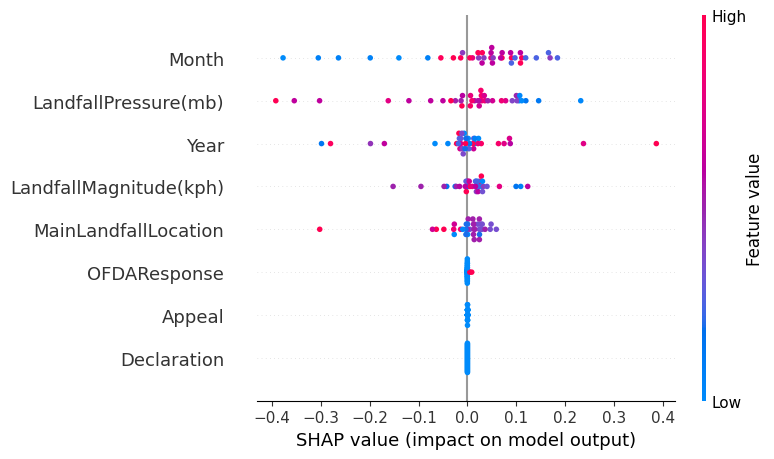

In [72]:
import shap
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 2.1.2 LightGBM

In [73]:
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 147, number of used features: 5
[LightGBM] [Info] Start training from score 0.829932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

LGBMRegressor()

In [74]:
lgb_importance = lgb_model.feature_importances_
lgb_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': lgb_importance}).sort_values(by='Importance', ascending=False)
print(lgb_importance_df)

                  Feature  Importance
0                    Year         151
7    LandfallPressure(mb)         100
6  LandfallMagnitude(kph)          99
2    MainLandfallLocation          57
1                   Month          54
3            OFDAResponse           0
4                  Appeal           0
5             Declaration           0


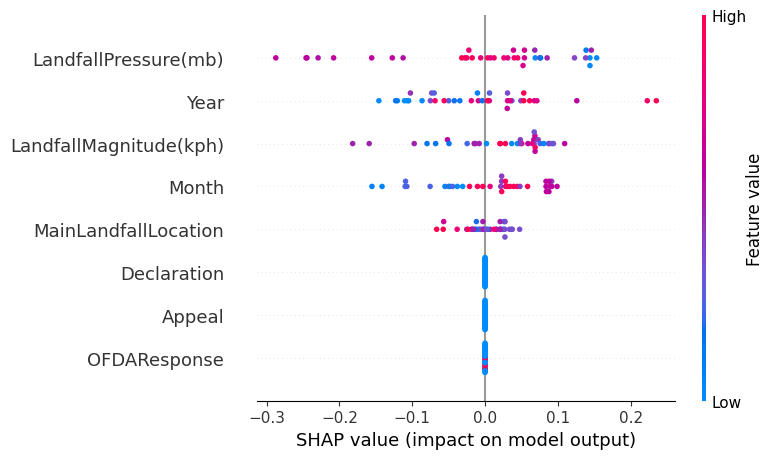

In [75]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)

# Plot the feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 2.1.3 CatBoost

In [76]:
# !pip install catboost

In [77]:
cat_model = CatBoostRegressor()
cat_model.fit(X_train, y_train)

Learning rate set to 0.030242
0:	learn: 0.3736679	total: 384us	remaining: 384ms
1:	learn: 0.3709531	total: 1.03ms	remaining: 512ms
2:	learn: 0.3689776	total: 1.63ms	remaining: 542ms
3:	learn: 0.3669878	total: 2.22ms	remaining: 554ms
4:	learn: 0.3646340	total: 2.78ms	remaining: 553ms
5:	learn: 0.3618291	total: 3.42ms	remaining: 567ms
6:	learn: 0.3585311	total: 3.77ms	remaining: 534ms
7:	learn: 0.3573671	total: 4.14ms	remaining: 513ms
8:	learn: 0.3554138	total: 4.72ms	remaining: 520ms
9:	learn: 0.3525755	total: 5.54ms	remaining: 549ms
10:	learn: 0.3507109	total: 6.13ms	remaining: 552ms
11:	learn: 0.3486745	total: 6.71ms	remaining: 552ms
12:	learn: 0.3462853	total: 7.3ms	remaining: 554ms
13:	learn: 0.3443763	total: 7.87ms	remaining: 555ms
14:	learn: 0.3426802	total: 8.55ms	remaining: 561ms
15:	learn: 0.3408363	total: 9.05ms	remaining: 556ms
16:	learn: 0.3391814	total: 9.63ms	remaining: 557ms
17:	learn: 0.3376704	total: 10.2ms	remaining: 555ms
18:	learn: 0.3341124	total: 10.7ms	remaining: 

In [78]:
cat_importance = cat_model.feature_importances_
cat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': cat_importance}).sort_values(by='Importance', ascending=False)
print(cat_importance_df)

                  Feature  Importance
1                   Month   24.222477
7    LandfallPressure(mb)   23.301976
0                    Year   22.878854
6  LandfallMagnitude(kph)   16.453045
2    MainLandfallLocation   12.177419
3            OFDAResponse    0.556520
4                  Appeal    0.409709
5             Declaration    0.000000


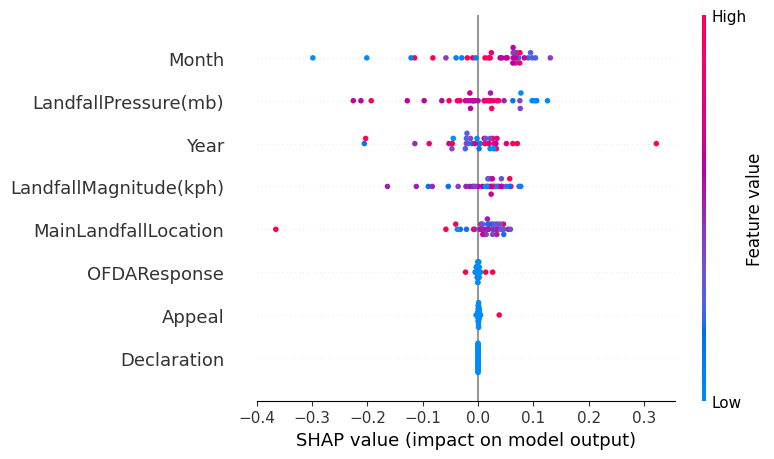

In [79]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_test)

# Plot the feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 2.1.4 Decision Trees (GBDT)

In [80]:
gbdt_model = GradientBoostingRegressor().fit(X_train, y_train)

In [81]:
gbdt_importance = gbdt_model.feature_importances_
gbdt_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': gbdt_importance}).sort_values(by='Importance', ascending=False)
print(gbdt_importance_df)

                  Feature  Importance
0                    Year    0.371095
1                   Month    0.259735
7    LandfallPressure(mb)    0.172816
6  LandfallMagnitude(kph)    0.124369
2    MainLandfallLocation    0.071335
4                  Appeal    0.000651
3            OFDAResponse    0.000000
5             Declaration    0.000000


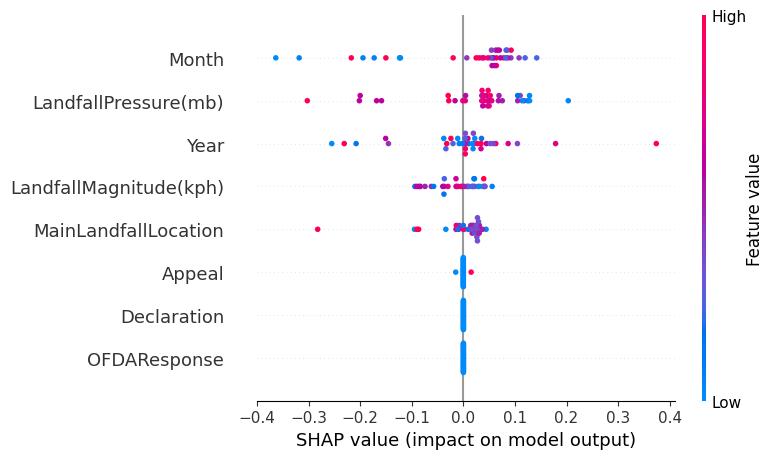

In [82]:
explainer = shap.TreeExplainer(gbdt_model)
shap_values = explainer.shap_values(X_test)

# Plot the feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)


### 1.1.5 COMPARISION

In [83]:
# Normalize and rank feature importance for each model
xgb_importance_df['Rank'] = xgb_importance_df['Importance'].rank(ascending=False)
lgb_importance_df['Rank'] = lgb_importance_df['Importance'].rank(ascending=False)
cat_importance_df['Rank'] = cat_importance_df['Importance'].rank(ascending=False)
gbdt_importance_df['Rank'] = gbdt_importance_df['Importance'].rank(ascending=False)

# Combine rankings into a single DataFrame
combined_ranks = pd.concat([
    xgb_importance_df.set_index('Feature')['Rank'].rename('XGBoost'),
    lgb_importance_df.set_index('Feature')['Rank'].rename('LightGBM'),
    cat_importance_df.set_index('Feature')['Rank'].rename('CatBoost'),
    gbdt_importance_df.set_index('Feature')['Rank'].rename('GBDT')
], axis=1)

# Calculate average rank for each feature across all models
combined_ranks['Average Rank'] = combined_ranks.mean(axis=1)

# Sort by average rank to identify the most important features
sorted_ranks = combined_ranks.sort_values(by='Average Rank')
print("Feature Rankings by Average Rank Across Models:")
print(sorted_ranks)


Feature Rankings by Average Rank Across Models:
                        XGBoost  LightGBM  CatBoost  GBDT  Average Rank
Feature                                                                
Year                        3.0       1.0       3.0   1.0         2.000
Month                       1.0       5.0       1.0   2.0         2.250
LandfallPressure(mb)        2.0       2.0       2.0   3.0         2.250
LandfallMagnitude(kph)      5.0       3.0       4.0   4.0         4.000
MainLandfallLocation        4.0       4.0       5.0   5.0         4.500
OFDAResponse                6.0       7.0       6.0   7.5         6.625
Appeal                      7.0       7.0       7.0   6.0         6.750
Declaration                 8.0       7.0       8.0   7.5         7.625


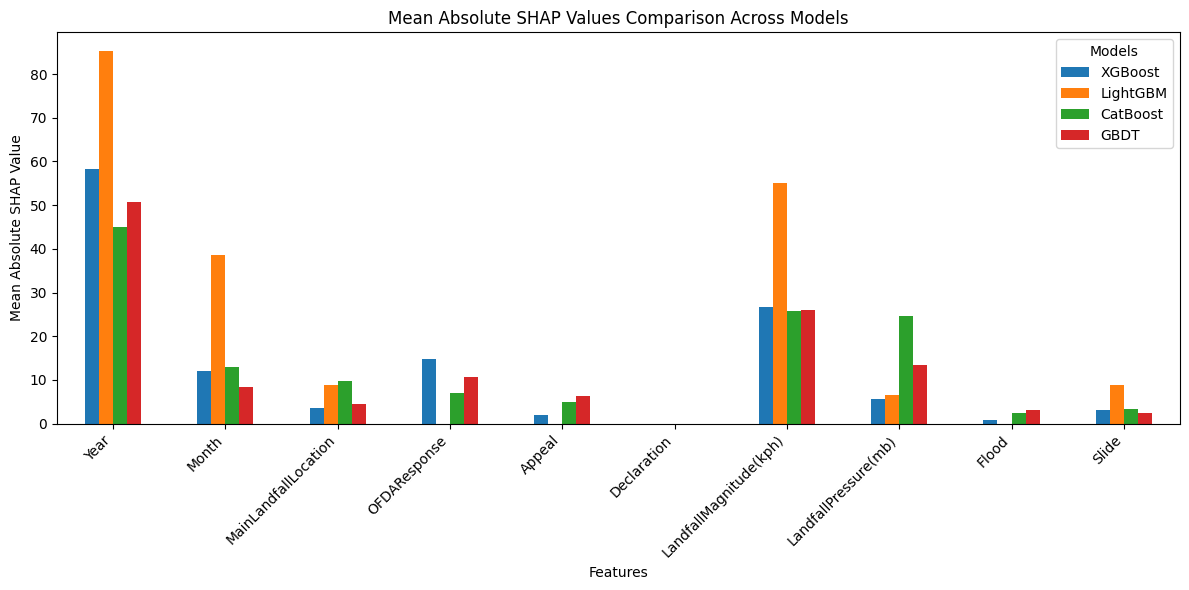

In [84]:
# Plot combined SHAP feature importance for all models
mean_abs_shap_df.plot(kind='bar', figsize=(12, 6))
plt.title('Mean Absolute SHAP Values Comparison Across Models')
plt.ylabel('Mean Absolute SHAP Value')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Models', loc='upper right')
plt.tight_layout()
plt.show()

In [85]:
import shap
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

models = [xgb_model, lgb_model, cat_model, gbdt_model]
model_names = ['XGBoost', 'LightGBM', 'CatBoost', 'GBDT']
feature_names = X_test.columns
mean_abs_shap_values = {}
ranked_features = {}

for model, name in zip(models, model_names):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    mean_abs_shap_values[name] = mean_abs_shap

    ranked_features[name] = pd.Series(mean_abs_shap, index=feature_names).rank(ascending=False)

mean_abs_shap_df = pd.DataFrame(mean_abs_shap_values, index=feature_names)
ranked_features_df = pd.DataFrame(ranked_features, index=feature_names)

rank_correlation_matrix = ranked_features_df.corr(method='spearman')

print("Mean Absolute SHAP Values:")
print(mean_abs_shap_df)

print("\nRank Correlation Matrix:")
print(rank_correlation_matrix)

Mean Absolute SHAP Values:
                         XGBoost  LightGBM  CatBoost      GBDT
Year                    0.062273  0.068431  0.047445  0.064501
Month                   0.096223  0.059665  0.072081  0.096595
MainLandfallLocation    0.030322  0.021902  0.036761  0.033787
OFDAResponse            0.000760  0.000000  0.003200  0.000000
Appeal                  0.000248  0.000000  0.002364  0.000999
Declaration             0.000000  0.000000  0.000000  0.000000
LandfallMagnitude(kph)  0.033028  0.063464  0.039849  0.036117
LandfallPressure(mb)    0.085563  0.093745  0.058125  0.083395

Rank Correlation Matrix:
           XGBoost  LightGBM  CatBoost      GBDT
XGBoost   1.000000  0.829515  1.000000  0.958101
LightGBM  0.829515  1.000000  0.829515  0.834497
CatBoost  1.000000  0.829515  1.000000  0.958101
GBDT      0.958101  0.834497  0.958101  1.000000


## 2.2.  Slide

In [86]:
from const import LINEAR_TARGETS

evaluate_dict = dict()

print(f"CATEGORICAL_TARGETS :{CATEGORICAL_TARGETS[1]}")
print(f"ATTRIBUTES :{ATTRIBUTES}")
feature_names = ATTRIBUTES

slide_df = base_df.copy()
X = slide_df[ATTRIBUTES]
y = slide_df[CATEGORICAL_TARGETS[1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train size {len(X_train)}")
print(f"Test size: {len(X_test)}")

CATEGORICAL_TARGETS :Slide
ATTRIBUTES :['Year', 'Month', 'MainLandfallLocation', 'OFDAResponse', 'Appeal', 'Declaration', 'LandfallMagnitude(kph)', 'LandfallPressure(mb)']
Train size 147
Test size: 37


### 2.2.1 XGBOOST

In [87]:
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [88]:
xgb_importance = xgb_model.feature_importances_

xgb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importance
}).sort_values(by='Importance', ascending=False)
print(xgb_importance_df)


                  Feature  Importance
4                  Appeal    0.329285
3            OFDAResponse    0.148877
7    LandfallPressure(mb)    0.136016
2    MainLandfallLocation    0.111162
6  LandfallMagnitude(kph)    0.103988
0                    Year    0.085556
1                   Month    0.085117
5             Declaration    0.000000


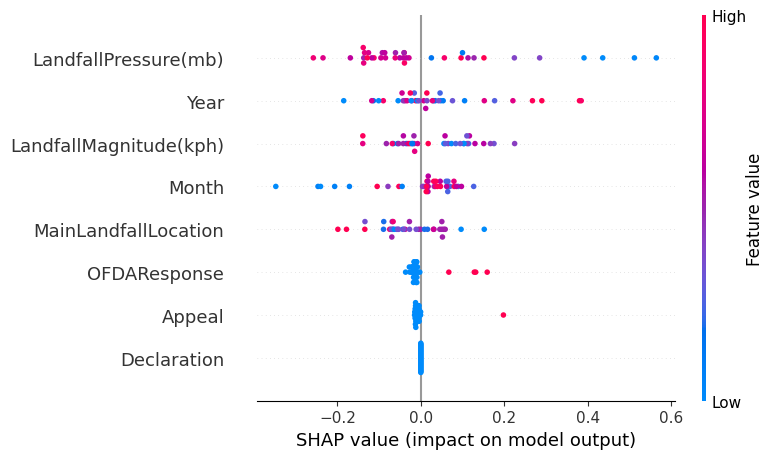

In [89]:
import shap
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 2.2.2 LightGBM

In [90]:
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 147, number of used features: 5
[LightGBM] [Info] Start training from score 0.374150
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

LGBMRegressor()

In [91]:
lgb_importance = lgb_model.feature_importances_
lgb_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': lgb_importance}).sort_values(by='Importance', ascending=False)
print(lgb_importance_df)

                  Feature  Importance
0                    Year         172
6  LandfallMagnitude(kph)          93
2    MainLandfallLocation          66
7    LandfallPressure(mb)          62
1                   Month          56
3            OFDAResponse           0
4                  Appeal           0
5             Declaration           0


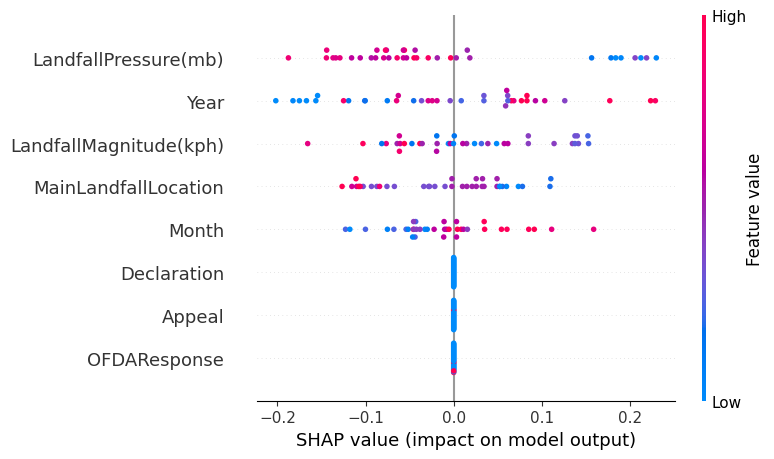

In [92]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)

# Plot the feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)


### 2.2.3 CatBoost

In [93]:
# !pip install catboost

In [94]:
cat_model = CatBoostRegressor()
cat_model.fit(X_train, y_train)

Learning rate set to 0.030242
0:	learn: 0.4832480	total: 299us	remaining: 300ms
1:	learn: 0.4814859	total: 649us	remaining: 324ms
2:	learn: 0.4807739	total: 831us	remaining: 276ms
3:	learn: 0.4801573	total: 1.05ms	remaining: 261ms
4:	learn: 0.4787167	total: 1.38ms	remaining: 274ms
5:	learn: 0.4768916	total: 1.76ms	remaining: 292ms
6:	learn: 0.4749873	total: 2.16ms	remaining: 306ms
7:	learn: 0.4741913	total: 2.86ms	remaining: 355ms
8:	learn: 0.4727953	total: 3.48ms	remaining: 383ms
9:	learn: 0.4712711	total: 4.12ms	remaining: 408ms
10:	learn: 0.4704114	total: 4.84ms	remaining: 436ms
11:	learn: 0.4685792	total: 5.58ms	remaining: 459ms
12:	learn: 0.4670738	total: 6.02ms	remaining: 457ms
13:	learn: 0.4659621	total: 6.54ms	remaining: 460ms
14:	learn: 0.4642665	total: 7ms	remaining: 460ms
15:	learn: 0.4630175	total: 7.51ms	remaining: 462ms
16:	learn: 0.4614651	total: 8.02ms	remaining: 464ms
17:	learn: 0.4595074	total: 8.54ms	remaining: 466ms
18:	learn: 0.4589035	total: 8.99ms	remaining: 464m

In [95]:
cat_importance = cat_model.feature_importances_
cat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': cat_importance}).sort_values(by='Importance', ascending=False)
print(cat_importance_df)

                  Feature  Importance
0                    Year   26.783603
7    LandfallPressure(mb)   23.833091
6  LandfallMagnitude(kph)   17.130593
2    MainLandfallLocation   16.186391
1                   Month   12.403057
3            OFDAResponse    1.994169
4                  Appeal    1.669096
5             Declaration    0.000000


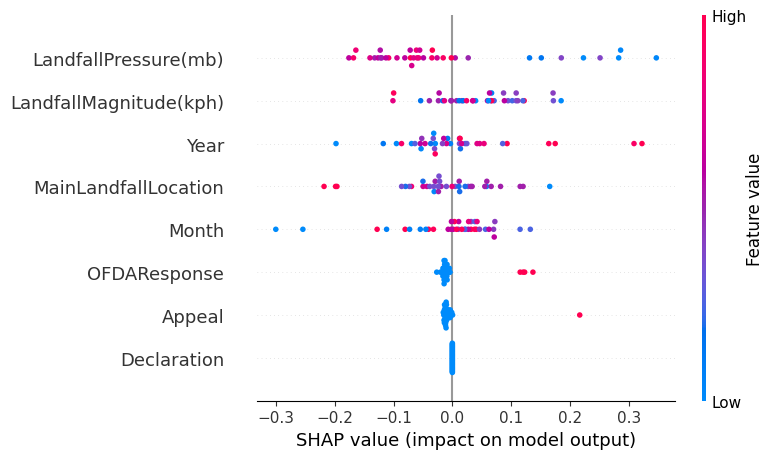

In [96]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_test)

# Plot the feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)


### 2.2.4 Decision Trees (GBDT)

In [97]:
gbdt_model = GradientBoostingRegressor().fit(X_train, y_train)

In [98]:
gbdt_importance = gbdt_model.feature_importances_
gbdt_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': gbdt_importance}).sort_values(by='Importance', ascending=False)
print(gbdt_importance_df)

                  Feature  Importance
7    LandfallPressure(mb)    0.312512
0                    Year    0.232433
6  LandfallMagnitude(kph)    0.185260
1                   Month    0.133384
2    MainLandfallLocation    0.077339
4                  Appeal    0.041851
3            OFDAResponse    0.017220
5             Declaration    0.000000


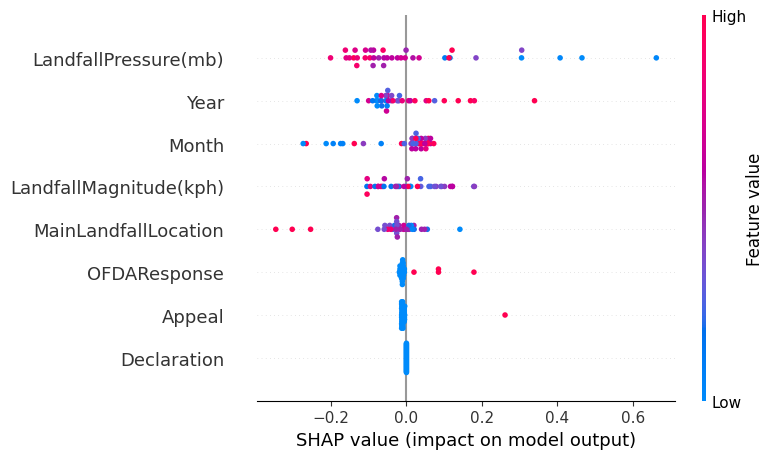

In [99]:
explainer = shap.TreeExplainer(gbdt_model)
shap_values = explainer.shap_values(X_test)

# Plot the feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 1.1.5 COMPARISION

In [100]:
# Normalize and rank feature importance for each model
xgb_importance_df['Rank'] = xgb_importance_df['Importance'].rank(ascending=False)
lgb_importance_df['Rank'] = lgb_importance_df['Importance'].rank(ascending=False)
cat_importance_df['Rank'] = cat_importance_df['Importance'].rank(ascending=False)
gbdt_importance_df['Rank'] = gbdt_importance_df['Importance'].rank(ascending=False)

# Combine rankings into a single DataFrame
combined_ranks = pd.concat([
    xgb_importance_df.set_index('Feature')['Rank'].rename('XGBoost'),
    lgb_importance_df.set_index('Feature')['Rank'].rename('LightGBM'),
    cat_importance_df.set_index('Feature')['Rank'].rename('CatBoost'),
    gbdt_importance_df.set_index('Feature')['Rank'].rename('GBDT')
], axis=1)

# Calculate average rank for each feature across all models
combined_ranks['Average Rank'] = combined_ranks.mean(axis=1)

# Sort by average rank to identify the most important features
sorted_ranks = combined_ranks.sort_values(by='Average Rank')
print("Feature Rankings by Average Rank Across Models:")
print(sorted_ranks)


Feature Rankings by Average Rank Across Models:
                        XGBoost  LightGBM  CatBoost  GBDT  Average Rank
Feature                                                                
LandfallPressure(mb)        3.0       4.0       2.0   1.0          2.50
Year                        6.0       1.0       1.0   2.0          2.50
LandfallMagnitude(kph)      5.0       2.0       3.0   3.0          3.25
MainLandfallLocation        4.0       3.0       4.0   5.0          4.00
Appeal                      1.0       7.0       7.0   6.0          5.25
Month                       7.0       5.0       5.0   4.0          5.25
OFDAResponse                2.0       7.0       6.0   7.0          5.50
Declaration                 8.0       7.0       8.0   8.0          7.75


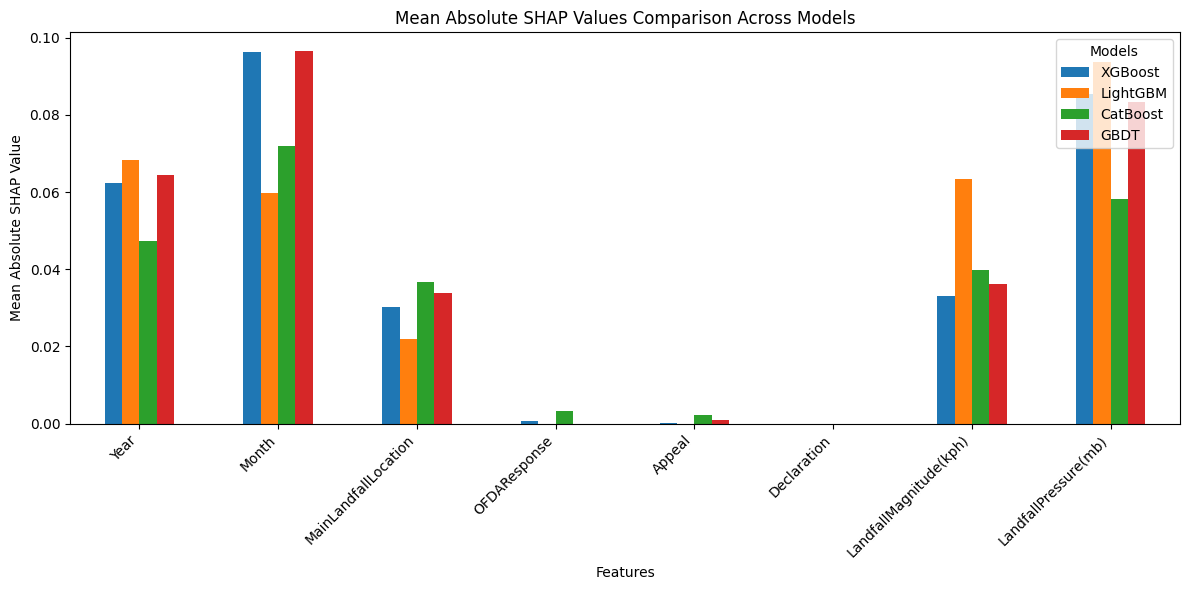

In [101]:
# Plot combined SHAP feature importance for all models
mean_abs_shap_df.plot(kind='bar', figsize=(12, 6))
plt.title('Mean Absolute SHAP Values Comparison Across Models')
plt.ylabel('Mean Absolute SHAP Value')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Models', loc='upper right')
plt.tight_layout()
plt.show()

In [102]:
import shap
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

models = [xgb_model, lgb_model, cat_model, gbdt_model]
model_names = ['XGBoost', 'LightGBM', 'CatBoost', 'GBDT']
feature_names = X_test.columns
mean_abs_shap_values = {}
ranked_features = {}

for model, name in zip(models, model_names):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    mean_abs_shap_values[name] = mean_abs_shap

    ranked_features[name] = pd.Series(mean_abs_shap, index=feature_names).rank(ascending=False)

mean_abs_shap_df = pd.DataFrame(mean_abs_shap_values, index=feature_names)
ranked_features_df = pd.DataFrame(ranked_features, index=feature_names)

rank_correlation_matrix = ranked_features_df.corr(method='spearman')

print("Mean Absolute SHAP Values:")
print(mean_abs_shap_df)

print("\nRank Correlation Matrix:")
print(rank_correlation_matrix)

Mean Absolute SHAP Values:
                         XGBoost  LightGBM  CatBoost      GBDT
Year                    0.089609  0.094343  0.067106  0.071601
Month                   0.076519  0.047226  0.057449  0.071180
MainLandfallLocation    0.064288  0.059386  0.059225  0.053114
OFDAResponse            0.026885  0.000000  0.024411  0.020225
Appeal                  0.013532  0.000000  0.014810  0.016343
Declaration             0.000000  0.000000  0.000000  0.000000
LandfallMagnitude(kph)  0.078139  0.067222  0.067169  0.066137
LandfallPressure(mb)    0.149520  0.101498  0.114326  0.137798

Rank Correlation Matrix:
           XGBoost  LightGBM  CatBoost      GBDT
XGBoost   1.000000  0.951503  0.952381  0.976190
LightGBM  0.951503  1.000000  0.951503  0.902708
CatBoost  0.952381  0.951503  1.000000  0.880952
GBDT      0.976190  0.902708  0.880952  1.000000
